In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# بسم الله الرحمن الرحيم توكلت على الله رب العالمين


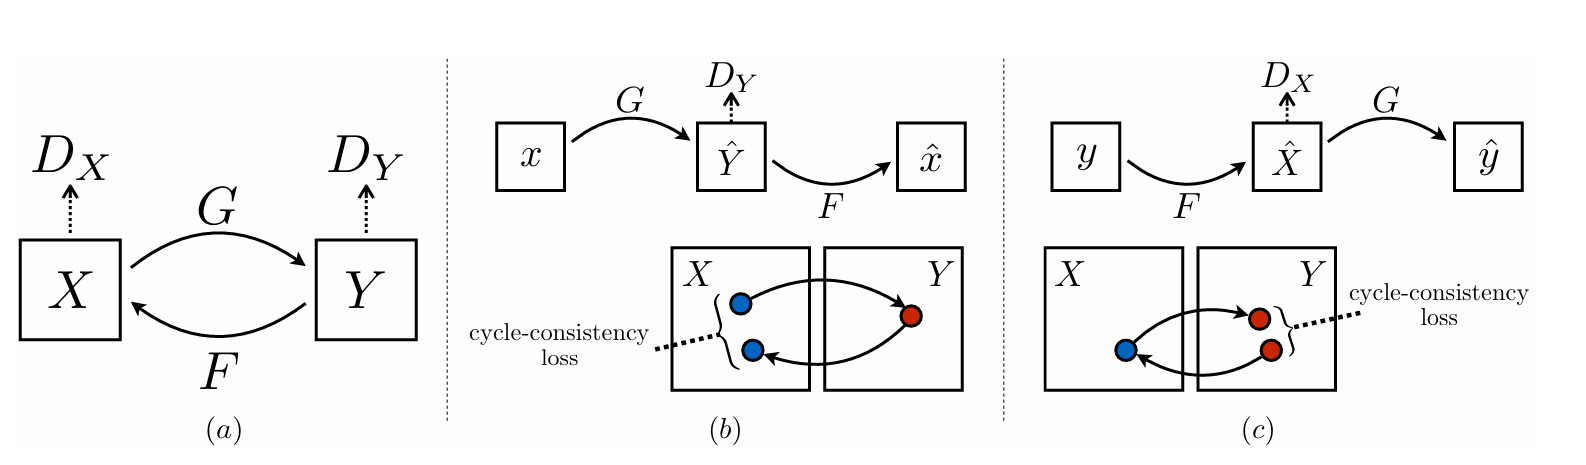

---

### **Project Overview**

This project implements a **CycleGAN (Cycle-Consistent Generative Adversarial Network)** for image-to-image translation between two domains: **CT (Computed Tomography) scans** and **MRI (Magnetic Resonance Imaging)**. The goal is to translate images from one domain (e.g., CT) to another (e.g., MRI) while preserving structural and semantic consistency.

The model uses **deep learning techniques** with PyTorch, leveraging **generative adversarial networks (GANs)** and **cycle-consistency loss** to ensure that the translated images are realistic and maintain the content of the original images. Additionally, the project evaluates the quality of the generated images using metrics such as **MSE, PSNR, SSIM, and FID**.

---

### **Key Components**

#### 1. **Dataset**
- The dataset consists of two domains:
  - **Domain A**: CT scans.
  - **Domain B**: MRI scans.
- Images are preprocessed using transformations such as resizing, normalization, and conversion to tensors.
- A custom `ImageDataset` class handles loading and preprocessing of the data.

#### 2. **Model Architecture**
- **Generators**:
  - Two generators (`G_AB` and `G_BA`) are used:
    - `G_AB`: Translates CT images to MRI images.
    - `G_BA`: Translates MRI images to CT images.
  - Architecture: Based on **ResNet**, with residual blocks, downsampling, and upsampling layers.
  - Output: Generates images in the target domain while maintaining the input's structure.
  
- **Discriminators**:
  - Two discriminators (`D_A` and `D_B`) are used:
    - `D_A`: Evaluates whether an image belongs to the CT domain.
    - `D_B`: Evaluates whether an image belongs to the MRI domain.
  - Architecture: Based on **PatchGAN**, which evaluates patches of the image rather than the entire image.

#### 3. **Loss Functions**
- **Adversarial Loss**:
  - Ensures that the generated images are realistic by fooling the discriminators.
- **Cycle-Consistency Loss**:
  - Ensures that translating an image from one domain to another and back results in the original image (cyclic consistency).
- **Identity Loss**:
  - Encourages the generator to preserve the identity of the input image when translating within the same domain.

#### 4. **Evaluation Metrics**
The quality of the generated images is evaluated using:
- **MSE (Mean Squared Error)**: Measures pixel-wise differences between real and generated images.
- **PSNR (Peak Signal-to-Noise Ratio)**: Quantifies the quality of the generated images in terms of signal strength.
- **SSIM (Structural Similarity Index)**: Captures structural similarity between real and generated images.
- **FID (Fréchet Inception Distance)**: Measures the statistical similarity between real and generated image distributions using features extracted from a pretrained InceptionV3 model.

#### 5. **Training Process**
- The training loop alternates between updating the **generators** and **discriminators**.
- Learning rates are adjusted dynamically using a **learning rate scheduler**.
- Metrics are calculated periodically (every 5 epochs) to monitor the performance of the model.

#### 6. **Visualization and Results**
- Generated images are visualized alongside real images during training to track progress.
- Metrics are displayed and saved for analysis.
- Checkpoints of the models are saved periodically for future use.

---

### **Summary**

This project aims to **translate medical images** between CT and MRI domains using a **CycleGAN** architecture. The key contributions include:
1. Implementation of **generators and discriminators** tailored for medical image translation.
2. Use of **cycle-consistency loss** to ensure meaningful translations.
3. Evaluation of generated images using **MSE, PSNR, SSIM, and FID** to quantify translation quality.
4. Visualization of results and periodic saving of checkpoints for reproducibility.

The project is designed to be modular, with clear separation of components such as data loading, model architecture, loss functions, and evaluation metrics. This makes it adaptable for other image-to-image translation tasks beyond medical imaging.

---

### **Applications**
- **Medical Imaging**: Enhancing or augmenting datasets by translating between imaging modalities.
- **Data Augmentation**: Generating synthetic data for training other machine learning models.
- **Cross-Domain Analysis**: Enabling comparison or integration of data from different imaging techniques.

---

### **Next Steps**
1. **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, and loss weights to improve performance.
2. **Larger Dataset**: Train on a larger and more diverse dataset to improve generalization.
3. **Advanced Architectures**: Explore newer architectures like **AttentionGAN** or **StarGAN** for improved results.
4. **Clinical Validation**: Validate the generated images with medical professionals to assess their clinical relevance.

---

This project provides a robust framework for **unsupervised image-to-image translation** and serves as a foundation for further research in medical imaging and beyond.

In [2]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy import linalg
from torchvision.models import inception_v3


### **Overview and Summary**

This code implements a **CycleGAN** for unsupervised image-to-image translation between two domains (CT and MRI scans). Key aspects include:

1. **Hyperparameters**:
   - Batch size: 1, Image size: 256x256, Learning rate: 0.0002, Epochs: 300.
   - Cycle-consistency loss weight (`lambda_cycle`): 10 to enforce meaningful translations.

2. **Data Preprocessing**:
   - Images are resized, converted to tensors, and normalized to the range [-1, 1] for training.

3. **Model Architecture**:
   - **Generators**: ResNet-based with residual blocks for translating images between domains.
   - **Discriminators**: PatchGAN architecture to evaluate realism of generated images.

4. **Loss Functions**:
   - Adversarial loss for realism, cycle-consistency loss for reconstruction, and identity loss for preserving input characteristics.

5. **Evaluation Metrics**:
   - MSE, PSNR, SSIM for pixel-wise and structural quality; FID for statistical similarity using InceptionV3 features.

6. **Training**:
   - Alternating updates for generators and discriminators.
   - Dynamic learning rate decay and periodic evaluation of metrics every 5 epochs.
   - Visualizations and checkpoints saved for monitoring progress.

7. **Applications**:
   - Translating medical images (CT ↔ MRI) while preserving structural consistency.
   - Potential for data augmentation, cross-domain analysis, and clinical validation.


In [3]:
# Hyperparameters
batch_size = 1
image_size = 256
lr = 0.0002
num_epochs = 30
lambda_cycle = 10  # Cycle-consistency loss weight
lambda_identity = 5  # Identity loss weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations for grayscale
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Single-channel normalization
])


### **Overview and Summary**

The `ImageDataset` class is a custom PyTorch dataset designed to handle paired image data from two domains (e.g., CT and MRI scans). Key points:

1. **Initialization**:
   - Accepts paths to two directories (`root_A` and `root_B`) containing images for the two domains.
   - Loads and sorts the filenames for both domains and applies optional transformations.

2. **Data Retrieval**:
   - The `__getitem__` method retrieves an image pair (`A` and `B`) by index, ensuring cyclic indexing if datasets differ in size.
   - Images are opened in RGB format and transformed (if specified).

3. **Length**:
   - The `__len__` method returns the size of the larger dataset, enabling balanced sampling between domains.

This implementation ensures seamless loading and preprocessing of paired image data for training tasks like CycleGAN.

In [4]:
# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.transform = transform
        try:
            self.files_A = sorted([f for f in os.listdir(root_A) if os.path.isfile(os.path.join(root_A, f))])
            self.files_B = sorted([f for f in os.listdir(root_B) if os.path.isfile(os.path.join(root_B, f))])
            if not self.files_A or not self.files_B:
                raise FileNotFoundError("No valid image files found in the specified directories.")
        except Exception as e:
            print(f"Error loading dataset: {e}")
            raise
        self.root_A = root_A
        self.root_B = root_B

    def __getitem__(self, index):
        img_A_path = os.path.join(self.root_A, self.files_A[index % len(self.files_A)])
        img_B_path = os.path.join(self.root_B, self.files_B[index % len(self.files_B)])
        try:
            img_A = Image.open(img_A_path).convert("L")  # Load as grayscale
            img_B = Image.open(img_B_path).convert("L")  # Load as grayscale
        except Exception as e:
            print(f"Error loading images {img_A_path} or {img_B_path}: {e}")
            raise
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


### **Overview and Summary**

The `Generator` class defines a **ResNet-based architecture** for image-to-image translation in a CycleGAN framework. Key points:

1. **Architecture**:
   - **Input Layer**: Reflection padding, convolution, instance normalization, and ReLU activation to process input images.
   - **Downsampling**: Two convolutional layers reduce spatial dimensions while increasing feature channels.
   - **Residual Blocks**: Nine residual blocks maintain the feature representation, enabling deeper networks without degradation.
   - **Upsampling**: Two transposed convolutional layers restore spatial dimensions while reducing feature channels.
   - **Output Layer**: Reflection padding, convolution, and Tanh activation produce the final output image.

2. **ResidualBlock**:
   - Implements skip connections to preserve information across layers, improving gradient flow and training stability.

3. **Purpose**:
   - The generator translates images from one domain (e.g., CT) to another (e.g., MRI) while maintaining structural consistency.

4. **Key Features**:
   - **Instance Normalization**: Ensures consistent scaling of activations.
   - **Reflection Padding**: Avoids boundary artifacts during convolution.
   - **Skip Connections**: Enable robust training of deep networks.

This modular design ensures high-quality image generation with minimal distortion, making it suitable for tasks like medical image translation.

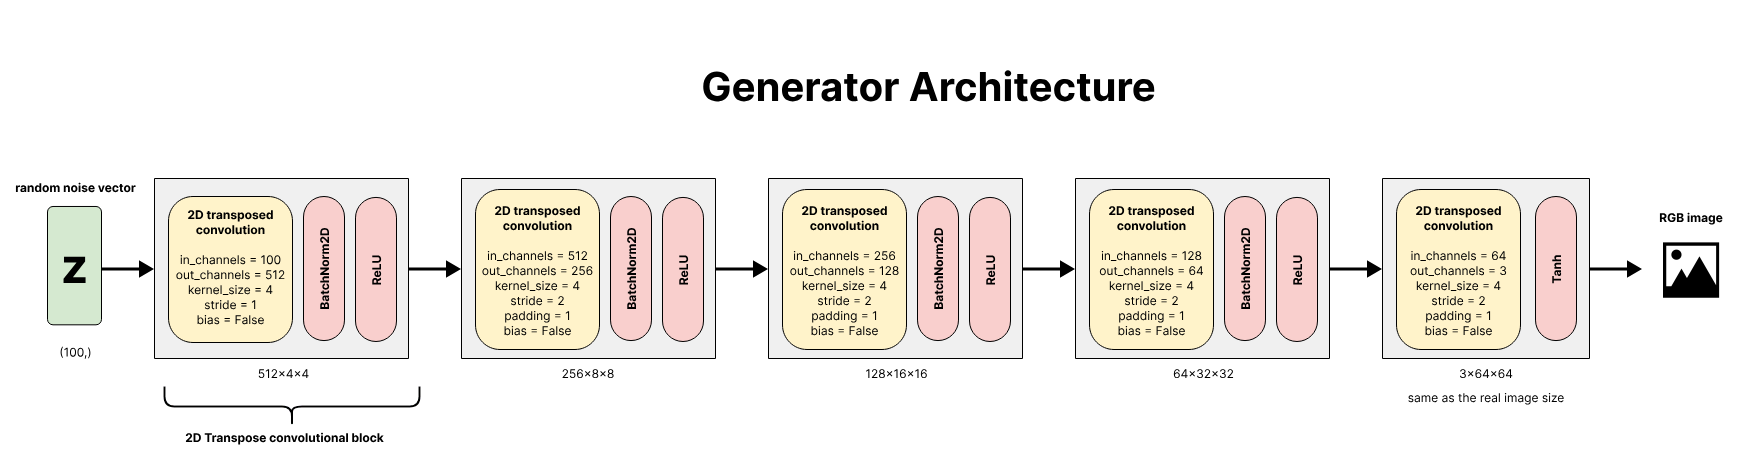

In [5]:
# Generator Network (U-Net architecture)
class Generator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

### **Overview and Summary**

The `Discriminator` class implements a **PatchGAN** architecture for evaluating the realism of images in a CycleGAN framework. Key points:

1. **Architecture**:
   - **Input Layer**: A convolutional layer with a kernel size of 4, stride of 2, and LeakyReLU activation to process input images.
   - **Downsampling Blocks**: Three blocks of convolution, instance normalization, and LeakyReLU progressively reduce spatial dimensions while increasing feature channels.
   - **Output Layer**: A final convolutional layer outputs a patch of logits (instead of a single scalar) to classify whether local image patches are real or fake.

2. **Purpose**:
   - The discriminator distinguishes between real images from the target domain and generated (fake) images produced by the generator.

3. **Key Features**:
   - **Instance Normalization**: Ensures consistent scaling of activations across batches.
   - **PatchGAN Design**: Focuses on local image regions, enabling finer-grained evaluation of realism.

This lightweight yet effective design ensures efficient training and high-quality image generation by providing precise feedback to the generator.

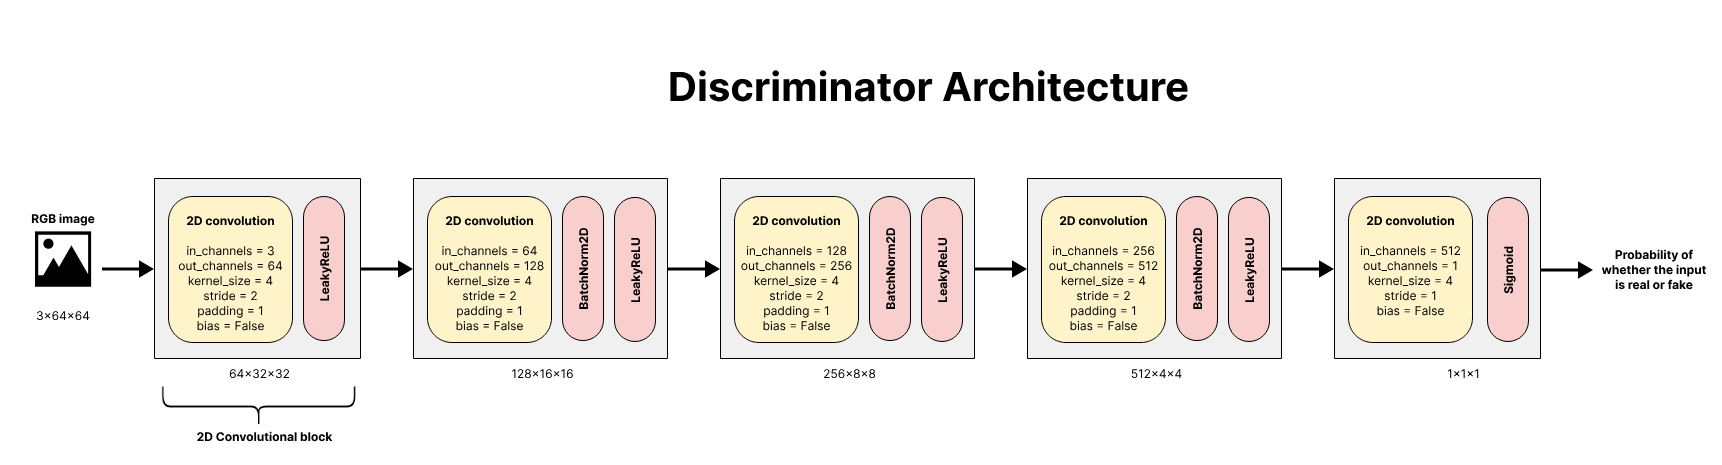

In [6]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

### **Overview and Summary**

The `FeatureExtractor` class is designed to extract feature representations from images using a pretrained **InceptionV3** model for calculating the **Fréchet Inception Distance (FID)**. Key points:

1. **Initialization**:
   - Loads the pretrained InceptionV3 model and removes its final classification layer (`fc`) to output intermediate features.
   - Sets the model to evaluation mode and disables gradient computation for its parameters to ensure it functions as a fixed feature extractor.

2. **Forward Method**:
   - Resizes input images to 299x299 if necessary, as InceptionV3 expects this specific input size.
   - Normalizes pixel values from the range [-1, 1] (common in GANs) to [0, 1], which is the expected input range for InceptionV3.
   - Extracts feature vectors from the penultimate layer of the InceptionV3 model.

3. **Purpose**:
   - The extracted features are used to compute the **FID score**, a metric that measures the statistical similarity between real and generated image distributions.

This implementation ensures efficient and reproducible feature extraction for evaluating the quality of generated images in tasks like GAN training.

In [7]:
# Feature Extractor for FID
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.inception = inception_v3(weights='DEFAULT', transform_input=False)
        self.inception.fc = nn.Identity()
        self.inception.eval()
        for param in self.inception.parameters():
            param.requires_grad = False

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # Convert grayscale to 3-channel for Inception
        if x.shape[2] != 299 or x.shape[3] != 299:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = (x + 1) / 2  # Denormalize to [0, 1]
        with torch.no_grad():
            features = self.inception(x)
        return features

### **Overview and Summary**

The `calculate_mse` function computes the **Mean Squared Error (MSE)** between two images, which is a common metric for measuring pixel-wise differences. Key points:

1. **Normalization**:
   - The input images are normalized from the range `[-1, 1]` (common in GANs) to `[0, 1]` to ensure proper computation.

2. **MSE Calculation**:
   - The function uses PyTorch's `F.mse_loss` to calculate the mean squared difference between corresponding pixels of the two images.

3. **Purpose**:
   - MSE quantifies the average squared difference between the generated and real images, providing a measure of image quality.

This simple yet effective function is used to evaluate how closely the generated images match the real images in terms of pixel values.

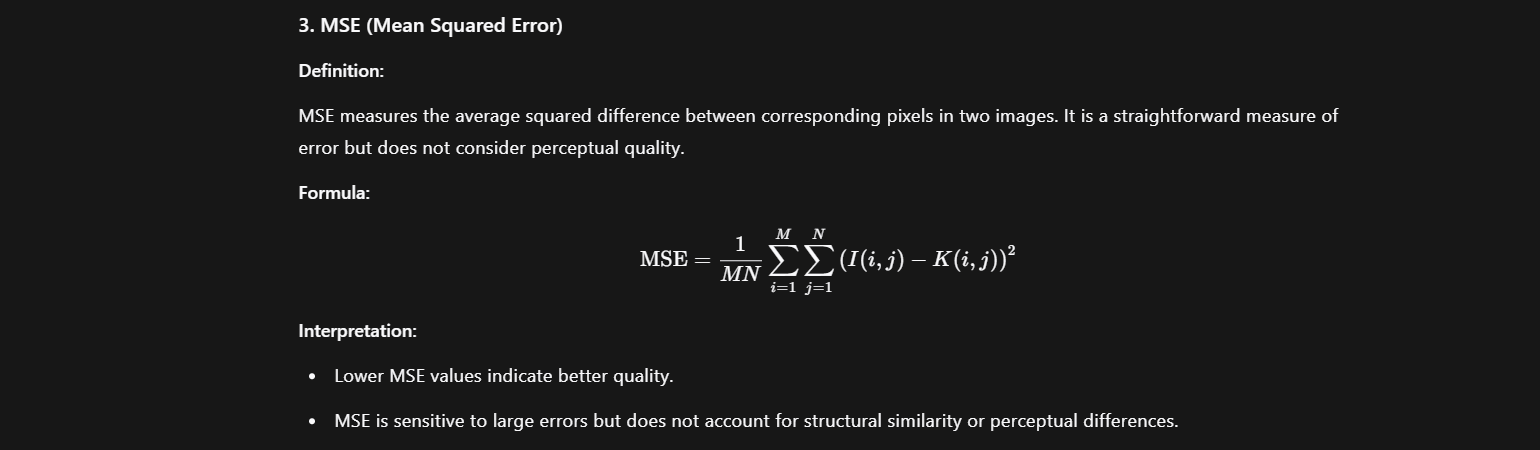

In [8]:
# Evaluation Metrics
def calculate_mse(img1, img2):
    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2
    return F.mse_loss(img1, img2).item()

### **Overview and Summary**

The `calculate_psnr` function computes the **Peak Signal-to-Noise Ratio (PSNR)** between two images, which is a metric used to measure image quality. Key points:

1. **Normalization**:
   - The input tensors are normalized from the range `[-1, 1]` to `[0, 1]` and converted to NumPy arrays for compatibility with the `psnr` function.

2. **Batch Handling**:
   - If the input contains a batch dimension (4D tensor), the function calculates PSNR for each image in the batch and returns the average PSNR value.
   - For single images (3D tensor), it directly computes the PSNR.

3. **Purpose**:
   - PSNR quantifies the quality of the generated images by comparing them to real images, with higher values indicating better quality.

This implementation ensures flexibility for both batched and single-image inputs, making it suitable for evaluating image translation tasks like those in CycleGAN.

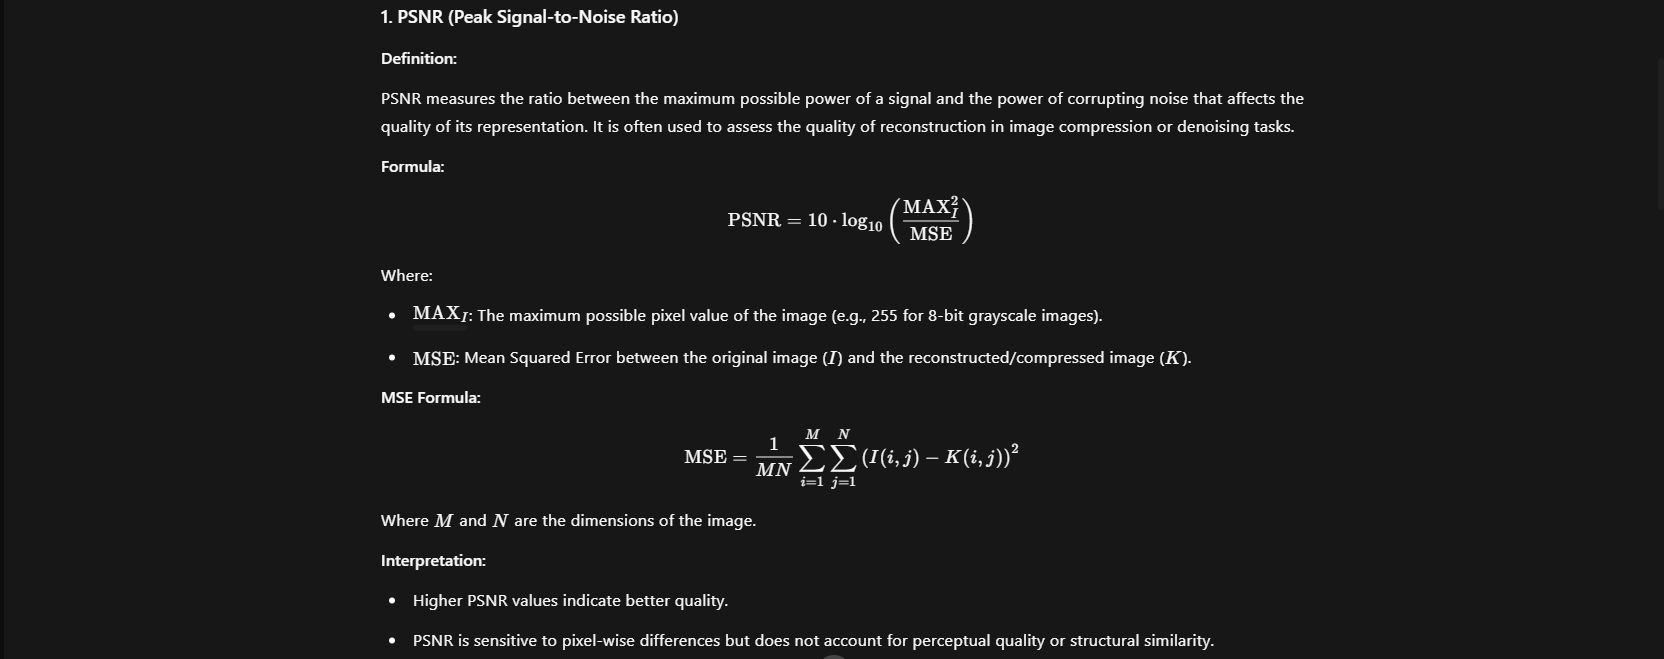

In [9]:
def calculate_psnr(img1, img2):
    img1_np = ((img1 + 1) / 2).clamp(0, 1).cpu().numpy()
    img2_np = ((img2 + 1) / 2).clamp(0, 1).cpu().numpy()
    if img1_np.ndim == 4:
        psnr_values = []
        for i in range(img1_np.shape[0]):
            psnr_values.append(psnr(img1_np[i].transpose(1, 2, 0), img2_np[i].transpose(1, 2, 0), data_range=1.0))
        return np.mean(psnr_values)
    else:
        return psnr(img1_np.transpose(1, 2, 0), img2_np.transpose(1, 2, 0), data_range=1.0)


### **Overview and Summary**

The `calculate_ssim` function computes the **Structural Similarity Index (SSIM)** between two images or batches of images, which measures perceptual similarity based on luminance, contrast, and structure. Key points:

1. **Normalization**:
   - The input tensors are normalized from the range `[-1, 1]` to `[0, 1]` and converted to NumPy arrays for compatibility with the `ssim` function.

2. **Batch Handling**:
   - If the input contains a batch dimension (4D tensor), the function calculates SSIM for each image in the batch and returns the average SSIM value.
   - For single images (3D tensor), it directly computes the SSIM.

3. **Purpose**:
   - SSIM evaluates how structurally similar the generated images are to the real images, with values closer to 1 indicating higher similarity.

This implementation ensures flexibility for both batched and single-image inputs, making it suitable for evaluating image translation tasks like those in CycleGAN.

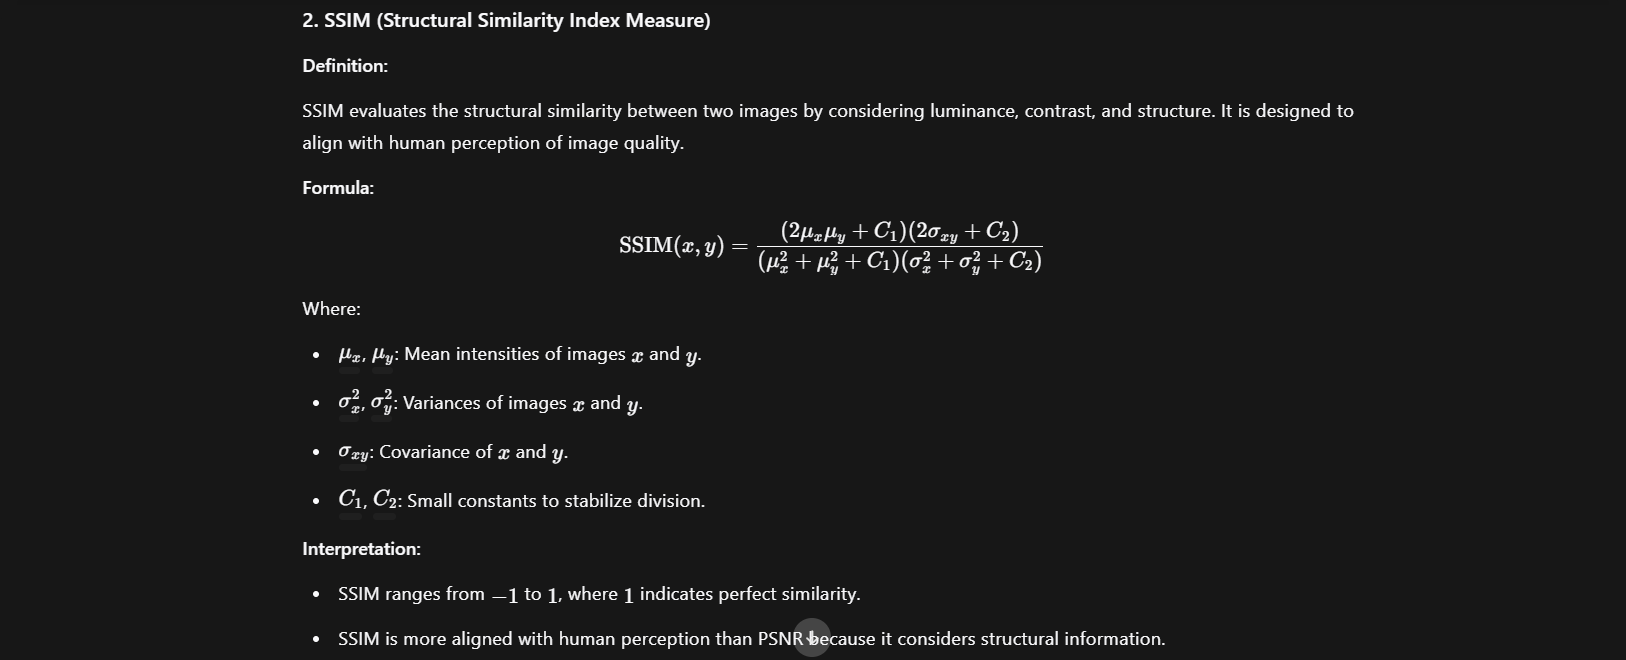

In [10]:
def calculate_ssim(img1, img2):
    img1_np = ((img1 + 1) / 2).clamp(0, 1).cpu().numpy()
    img2_np = ((img2 + 1) / 2).clamp(0, 1).cpu().numpy()
    if img1_np.ndim == 4:
        ssim_values = []
        for i in range(img1_np.shape[0]):
            # For grayscale, no transpose needed after squeeze
            ssim_values.append(ssim(img1_np[i].squeeze(), img2_np[i].squeeze(), data_range=1.0, win_size=7))
        return np.mean(ssim_values)
    else:
        return ssim(img1_np.squeeze(), img2_np.squeeze(), data_range=1.0, win_size=7)


### **Overview and Summary**

The `calculate_fid` function computes the **Fréchet Inception Distance (FID)**, a metric used to evaluate the quality of generated images by comparing their feature distributions to those of real images. Key points:

1. **Input Handling**:
   - Converts input feature vectors (real and fake) to NumPy arrays if they are PyTorch tensors.

2. **Statistical Calculations**:
   - Computes the mean (`mu1`, `mu2`) and covariance (`sigma1`, `sigma2`) of the feature vectors for both real and generated images.

3. **FID Formula**:
   - Calculates the squared difference between the means (`ssdiff`).
   - Computes the square root of the product of the covariance matrices (`covmean`), ensuring numerical stability by adding a small epsilon to the diagonal.
   - Combines these components into the FID score using the formula:
     \[
     \text{FID} = \text{ssdiff} + \text{Tr}(\Sigma_1 + \Sigma_2 - 2.0 \cdot \text{covmean})
     \]

4. **Purpose**:
   - FID quantifies the statistical similarity between real and generated image distributions, with lower scores indicating better quality.

This implementation ensures robustness by handling complex numbers and stabilizing covariance matrix calculations, making it suitable for evaluating generative models like GANs.

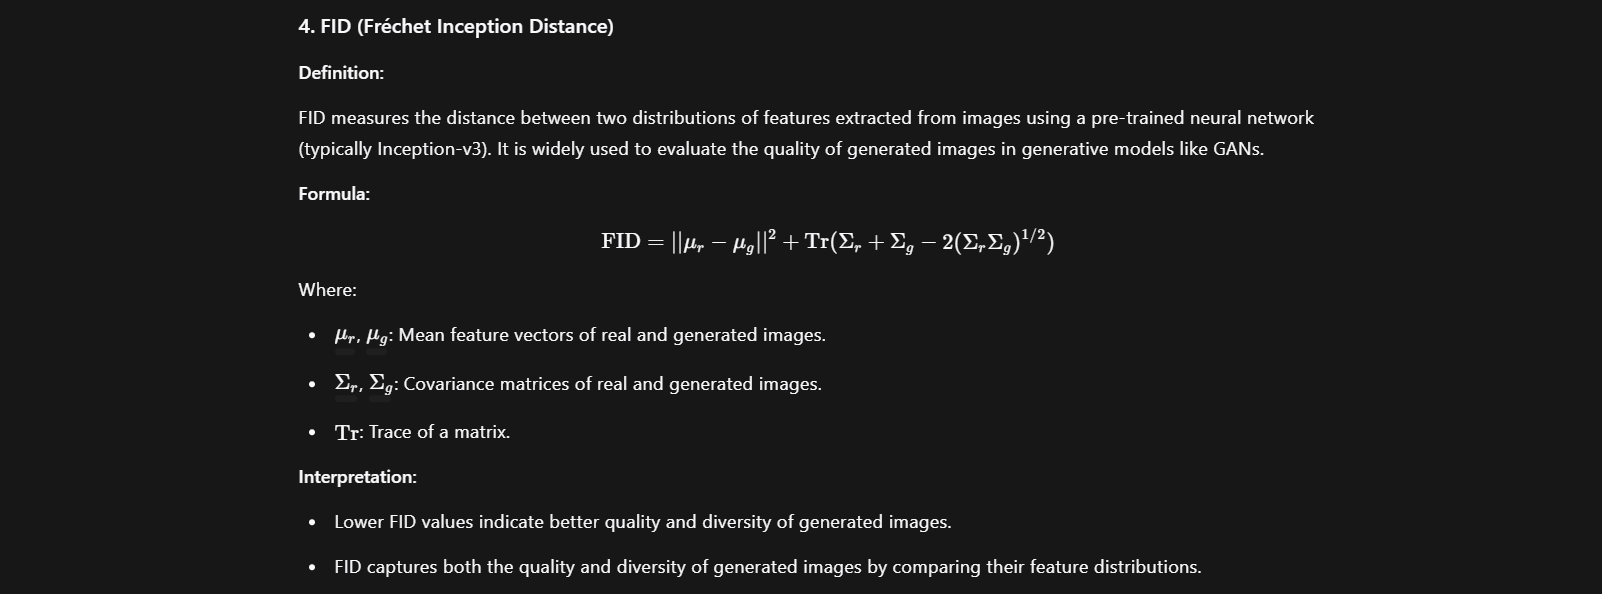

In [11]:
def calculate_fid(real_features, fake_features):
    mu1 = np.mean(real_features, axis=0)
    sigma1 = np.cov(real_features, rowvar=False)
    mu2 = np.mean(fake_features, axis=0)
    sigma2 = np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### **Overview and Summary**

The `extract_features_for_fid` function is designed to compute feature representations of real and generated images for calculating the **Fréchet Inception Distance (FID)**. Key points:

1. **Purpose**:
   - Extracts features from real and generated images using a pretrained feature extractor (e.g., InceptionV3).
   - These features are used to evaluate the statistical similarity between real and generated image distributions.

2. **Input Parameters**:
   - `generator`: The generator model that produces fake images from real ones.
   - `feature_extractor`: A pretrained model (e.g., InceptionV3) that extracts feature vectors.
   - `dataloader`: Provides batches of real images from both domains (CT and MRI).
   - `target_domain`: Specifies the direction of translation (`'B'` for CT → MRI, `'A'` for MRI → CT).

3. **Process**:
   - Iterates through the dataset in batches.
   - For each batch:
     - Generates fake images using the generator.
     - Extracts features for both real and fake images using the feature extractor.
     - Appends the extracted features to lists for later concatenation.
   - Concatenates all feature vectors into NumPy arrays for real and fake images.

4. **Output**:
   - Returns two NumPy arrays:
     - `real_features`: Feature vectors of real images.
     - `fake_features`: Feature vectors of generated (fake) images.

5. **Applications**:
   - Used to compute FID scores, which quantify how closely the distribution of generated images matches the real image distribution.

This implementation ensures efficient and modular extraction of features, making it suitable for evaluating generative models like GANs in tasks such as medical image translation.

In [12]:
def extract_features_for_fid(generator, feature_extractor, dataloader):
    real_features = []
    fake_features = []
    with torch.no_grad():
        for batch in dataloader:
            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)
            fake_B = generator(real_A)
            real_feats = feature_extractor(real_B)
            fake_feats = feature_extractor(fake_B)
            real_features.append(real_feats.cpu().numpy())
            fake_features.append(fake_feats.cpu().numpy())
    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)
    return real_features, fake_features

### **Overview and Summary**

The `display_images_and_metrics` function is designed to visualize real and generated images during the training process of a CycleGAN model, along with optional evaluation metrics. Key points:

1. **Purpose**:
   - Displays a 2x2 grid of images showing:
     - Real CT (`real_A`), Generated MRI (`fake_B`),
     - Real MRI (`real_B`), Generated CT (`fake_A`).
   - Optionally displays evaluation metrics (e.g., MSE, PSNR, SSIM, FID) as text below the grid.

2. **Image Processing**:
   - Images are denormalized from the range `[-1, 1]` to `[0, 1]` for proper visualization.
   - The `squeeze`, `permute`, and `detach` operations ensure compatibility with `matplotlib` for display.

3. **Metrics Display**:
   - If metrics are provided, they are formatted as key-value pairs and displayed below the image grid in a visually distinct box.

4. **Saving Results**:
   - Saves the displayed images (real and generated) into the `results` directory as a single concatenated grid for each epoch.

5. **Directory Setup**:
   - Ensures the existence of directories (`results` and `checkpoints`) for saving outputs and model checkpoints.

This function provides an intuitive way to monitor the progress of the CycleGAN training by visualizing both qualitative results (images) and quantitative metrics.

In [13]:
# Visualization Function
def display_images_and_metrics(real_A, fake_B, recovered_A, epoch, metrics=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ["Real CT", "Generated MRI", "Recovered CT"]
    images = [real_A, fake_B, recovered_A]
    for i, ax in enumerate(axes.flatten()):
        img = images[i].squeeze().cpu().detach().numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        ax.imshow(img, cmap='gray')  # Display as grayscale
        ax.set_title(titles[i], fontsize=14)
        ax.axis("off")
    plt.suptitle(f"Epoch {epoch}", fontsize=16)
    if metrics:
        metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in metrics.items()])
        plt.figtext(0.5, 0.01, metrics_text, ha="center", fontsize=12,
                   bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    os.makedirs('results', exist_ok=True)
    save_image(torch.cat([real_A, fake_B, recovered_A], 0),
               f"results/epoch_{epoch}.png", nrow=3, normalize=True)
    plt.savefig(f'results/metrics_epoch_{epoch}.png')
    plt.close()

### **Overview and Summary**

This section of the code sets up the core components for training a **CycleGAN** model to translate images between two domains: **CT scans (domain A)** and **MRI scans (domain B)**. Below is a concise breakdown:

---

### **1. Loss Functions**
- **Adversarial Loss (`criterion_GAN`)**:
  - Uses **MSE Loss** to ensure generated images fool the discriminators.
- **Cycle-Consistency Loss (`criterion_cycle`)**:
  - Uses **L1 Loss** to enforce that translating an image from one domain to another and back results in the original image.
- **Identity Loss (`criterion_identity`)**:
  - Also uses **L1 Loss** to preserve the identity of images when translated within the same domain.

---

### **2. Model Initialization**
- **Generators**:
  - `G_AB`: Translates CT images to MRI images.
  - `G_BA`: Translates MRI images to CT images.
- **Discriminators**:
  - `D_A`: Evaluates whether an image belongs to the CT domain.
  - `D_B`: Evaluates whether an image belongs to the MRI domain.
- **Feature Extractor**:
  - A pretrained InceptionV3 model (`feature_extractor`) is used to compute features for **FID (Fréchet Inception Distance)** evaluation.

---

### **3. Optimizers**
- **Generator Optimizer (`optimizer_G`)**:
  - Combines parameters of both generators (`G_AB` and `G_BA`) and uses the Adam optimizer with learning rate `lr=0.0002` and betas `(0.5, 0.999)`.
- **Discriminator Optimizers (`optimizer_D_A`, `optimizer_D_B`)**:
  - Separate Adam optimizers for the two discriminators, with the same learning rate and betas.

---

### **4. Learning Rate Scheduler**
- Implements a **LambdaLR scheduler** for all optimizers, reducing the learning rate linearly over epochs:
  \[
  \text{lr} = \text{initial\_lr} \times (1 - \frac{\text{epoch}}{\text{num\_epochs}})
  \]

---

### **5. Dataset and DataLoader**
- **Dataset**:
  - Custom `ImageDataset` class loads and preprocesses CT and MRI images from specified directories (`root_A` and `root_B`).
- **DataLoader**:
  - Provides batches of paired images (`real_A` and `real_B`) with shuffling enabled.

---

### **6. Metrics History**
- A dictionary (`metrics_history`) is initialized to store evaluation metrics across epochs:
  - **Losses**: Generator (`G_loss`), Discriminator A (`D_A_loss`), Discriminator B (`D_B_loss`).
  - **Image Quality Metrics**:
    - **MSE**: Mean Squared Error for both translation directions.
    - **PSNR**: Peak Signal-to-Noise Ratio for both translation directions.
    - **SSIM**: Structural Similarity Index for both translation directions.
    - **FID**: Fréchet Inception Distance for both translation directions.

---

### **Purpose**
This setup ensures that the CycleGAN model can be trained effectively to translate images between CT and MRI domains while maintaining structural consistency. The use of multiple loss functions, optimizers, and evaluation metrics ensures high-quality and realistic translations.

---

### **Next Steps**
1. **Training Loop**:
   - Implement alternating updates for generators and discriminators.
   - Compute and log losses and metrics periodically.
2. **Visualization**:
   - Display real and generated images during training to monitor progress.
3. **Model Saving**:
   - Save generator and discriminator checkpoints periodically for future use.

In [14]:
# Initialize Models and Loss Functions
G_AB = Generator(input_channels=1, output_channels=1).to(device)  # CT -> MRI
G_BA = Generator(input_channels=1, output_channels=1).to(device)  # MRI -> CT
D_B = Discriminator(input_channels=1).to(device)  # Discriminator for MRI
feature_extractor = FeatureExtractor().to(device)
criterion_GAN = nn.MSELoss()
criterion_L1 = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Learning Rate Schedulers
lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1 - epoch / num_epochs)
lr_scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda epoch: 1 - epoch / num_epochs)

# Load Dataset
root_A = r"/content/drive/MyDrive/Final_Data/train A-20250505T142254Z-1-001/train A"
root_B = r"/content/drive/MyDrive/Final_Data/Train B-20250505T142535Z-1-001/Train B"
try:
    dataset = ImageDataset(root_A=root_A, root_B=root_B, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
except Exception as e:
    print(f"Failed to load dataset: {e}")
    raise

# Metrics History
metrics_history = {
    'G_loss': [], 'D_B_loss': [],
    'CT_to_MRI_MSE': [], 'CT_to_MRI_PSNR': [], 'CT_to_MRI_SSIM': [], 'CT_to_MRI_FID': [],
    'Recovered_CT_MSE': []
}

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 204MB/s]


### **Overview and Summary**

This Training
 ** loop** and **evaluation process** for a **CycleGAN** model designed to translate images between two domains: **CT scans (domain A)** and **MRI scans (domain B)**. Below is a concise and structured summary:

---

### **1. Training Loop**
- Iterates over `num_epochs` and processes batches of data from the `dataloader`.
- **Key Steps**:
  - **Initialization**: Resets metrics (`G_loss`, `D_A_loss`, `D_B_loss`) and retrieves real images (`real_A` for CT, `real_B` for MRI).
  - **Adversarial Ground Truths**: Defines labels for real (`valid`) and fake (`fake`) images.
  - **Generator Training**:
    - **Identity Loss**: Ensures identity preservation when translating within the same domain.
    - **GAN Loss**: Encourages generated images to fool discriminators.
    - **Cycle Loss**: Enforces cycle-consistency by reconstructing the original image after two translations.
    - Combines losses into `loss_G` and updates generator parameters.
  - **Discriminator Training**:
    - Trains discriminators (`D_A`, `D_B`) to distinguish real from fake images.
    - Updates discriminator parameters using gradients.
  - **Logging**: Accumulates losses and periodically prints progress.

---

### **2. Learning Rate Scheduling**
- Uses a **linear decay schedule** (`lr_scheduler_G`, `lr_scheduler_D_A`, `lr_scheduler_D_B`) to reduce learning rates over epochs:
  \[
  \text{lr} = \text{initial\_lr} \times (1 - \frac{\text{epoch}}{\text{num\_epochs}})
  \]

---

### **3. Evaluation and Metrics**
- Conducted every 5 epochs (or at the last epoch) to assess model performance.
- **Metrics**:
  - **MSE, PSNR, SSIM**: Quantify pixel-wise differences, signal quality, and structural similarity.
  - **FID**: Measures statistical similarity using features from a pretrained InceptionV3 model.
- **Key Steps**:
  - Generates fake images (`fake_B` for CT → MRI, `fake_A` for MRI → CT).
  - Computes metrics for a sample batch:
    - **MSE, PSNR, SSIM**: Directly calculated from real and fake images.
    - **FID**: Computed every 10 epochs or at the last epoch.
  - Displays images and metrics using `display_images_and_metrics`.

---

### **4. Model Saving**
- Saves generator and discriminator checkpoints periodically (every 20 epochs or at the last epoch) for future use.

---

### **5. Plotting Training Metrics**
- After training, plots the following metrics over epochs:
  - **Losses**: Generator loss, Discriminator A loss, Discriminator B loss.
  - **Image Quality Metrics**: MSE, PSNR, SSIM, FID for both translation directions (CT → MRI, MRI → CT).
- Saves plots as `training_metrics.png` in the `results` directory.

---

### **6. Final Output**
- Prints "Training and evaluation complete!" upon finishing all epochs.
- Saves:
  - Generated images.
  - Model checkpoints.
  - Metric plots for analysis.

---

### **Purpose**
This implementation ensures a robust and modular training process with periodic evaluation and visualization, making it suitable for tasks like medical image translation (CT ↔ MRI). It balances quality metrics, computational efficiency, and reproducibility.

In [15]:

# Training Loop
for epoch in range(num_epochs):
    epoch_G_loss = 0
    epoch_D_B_loss = 0
    epoch_samples = 0
    for i, batch in enumerate(dataloader):
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)
        valid_size_B = D_B(real_B).size()
        valid_B = torch.ones(valid_size_B, device=device)
        fake_B = torch.zeros(valid_size_B, device=device)

        # Train Generators
        optimizer_G.zero_grad()
        fake_B_img = G_AB(real_A)
        recovered_A = G_BA(fake_B_img)
        identity_B = G_AB(real_B)
        loss_GAN = criterion_GAN(D_B(fake_B_img), valid_B)
        loss_cycle_A = criterion_L1(recovered_A, real_A) * lambda_cycle
        loss_identity_B = criterion_identity(identity_B, real_B) * lambda_identity
        loss_L1 = criterion_L1(fake_B_img, real_B) * lambda_cycle
        loss_G = loss_GAN + loss_cycle_A + loss_L1 + loss_identity_B
        loss_G.backward()
        torch.nn.utils.clip_grad_norm_(list(G_AB.parameters()) + list(G_BA.parameters()), max_norm=1.0)
        optimizer_G.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_real_B = criterion_GAN(D_B(real_B), valid_B)
        loss_fake_B = criterion_GAN(D_B(fake_B_img.detach()), fake_B)
        loss_D_B = (loss_real_B + loss_fake_B) / 2
        loss_D_B.backward()
        torch.nn.utils.clip_grad_norm_(D_B.parameters(), max_norm=1.0)
        optimizer_D_B.step()

        epoch_G_loss += loss_G.item()
        epoch_D_B_loss += loss_D_B.item()
        epoch_samples += 1

        if i < 1:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D_B loss: {loss_D_B.item():.4f}] [G loss: {loss_G.item():.4f}]")

    lr_scheduler_G.step()
    lr_scheduler_D_B.step()

    avg_G_loss = epoch_G_loss / epoch_samples
    avg_D_B_loss = epoch_D_B_loss / epoch_samples
    metrics_history['G_loss'].append(avg_G_loss)
    metrics_history['D_B_loss'].append(avg_D_B_loss)

    # Evaluation
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            sample_batch = next(iter(dataloader))
            real_A = sample_batch["A"].to(device)
            real_B = sample_batch["B"].to(device)
            fake_B = G_AB(real_A)
            recovered_A = G_BA(fake_B)

            mse_CT_to_MRI = calculate_mse(real_B, fake_B)
            psnr_CT_to_MRI = calculate_psnr(real_B, fake_B)
            ssim_CT_to_MRI = calculate_ssim(real_B, fake_B)
            mse_recovered_CT = calculate_mse(real_A, recovered_A)
            real_features, fake_features = extract_features_for_fid(G_AB, feature_extractor, dataloader)
            fid_score = calculate_fid(real_features, fake_features)

            metrics_history['CT_to_MRI_MSE'].append(mse_CT_to_MRI)
            metrics_history['CT_to_MRI_PSNR'].append(psnr_CT_to_MRI)
            metrics_history['CT_to_MRI_SSIM'].append(ssim_CT_to_MRI)
            metrics_history['CT_to_MRI_FID'].append(fid_score)
            metrics_history['Recovered_CT_MSE'].append(mse_recovered_CT)

            current_metrics = {
                'MSE_CT_to_MRI': mse_CT_to_MRI,
                'PSNR_CT_to_MRI': psnr_CT_to_MRI,
                'SSIM_CT_to_MRI': ssim_CT_to_MRI,
                'FID_CT_to_MRI': fid_score,
                'MSE_Recovered_CT': mse_recovered_CT
            }

            display_images_and_metrics(real_A, fake_B, recovered_A, epoch, current_metrics)
    else:
        with torch.no_grad():
            sample_batch = next(iter(dataloader))
            real_A = sample_batch["A"].to(device)
            fake_B = G_AB(real_A)
            recovered_A = G_BA(fake_B)
            display_images_and_metrics(real_A, fake_B, recovered_A, epoch)

    # Save Checkpoints
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        os.makedirs("/content/checkpoints", exist_ok=True)
        checkpoint = {
            'epoch': epoch,
            'G_AB_state_dict': G_AB.state_dict(),
            'G_BA_state_dict': G_BA.state_dict(),
            'D_B_state_dict': D_B.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_B_state_dict': optimizer_D_B.state_dict()
        }
        torch.save(checkpoint, f"/content/checkpoints/cyclegan_epoch_{epoch}.pth")

# Plot Metrics
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(metrics_history['G_loss'], label='Generator Loss')
plt.plot(metrics_history['D_B_loss'], label='Discriminator B Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(metrics_history['CT_to_MRI_MSE'], label='CT to MRI MSE')
plt.plot(metrics_history['Recovered_CT_MSE'], label='Recovered CT MSE')
plt.title('Mean Squared Error')
plt.xlabel('Evaluation Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(metrics_history['CT_to_MRI_PSNR'], label='CT to MRI PSNR')
plt.title('Peak Signal-to-Noise Ratio')
plt.xlabel('Evaluation Epoch')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(metrics_history['CT_to_MRI_SSIM'], label='CT to MRI SSIM')
plt.title('Structural Similarity Index')
plt.xlabel('Evaluation Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(metrics_history['CT_to_MRI_FID'], label='CT to MRI FID')
plt.title('Frechet Inception Distance')
plt.xlabel('Evaluation Epoch')
plt.ylabel('FID')
plt.legend()
plt.grid(True)

plt.tight_layout()
os.makedirs('results', exist_ok=True)
plt.savefig('results/training_metrics.png')
plt.close()

print("Training Completed")

[Epoch 0/30] [Batch 0/366] [D_B loss: 0.7664] [G loss: 20.8499]
[Epoch 1/30] [Batch 0/366] [D_B loss: 0.4245] [G loss: 4.3553]
[Epoch 2/30] [Batch 0/366] [D_B loss: 0.2641] [G loss: 4.3595]
[Epoch 3/30] [Batch 0/366] [D_B loss: 0.0885] [G loss: 3.8116]
[Epoch 4/30] [Batch 0/366] [D_B loss: 0.1548] [G loss: 4.7258]
[Epoch 5/30] [Batch 0/366] [D_B loss: 0.1116] [G loss: 3.8410]
[Epoch 6/30] [Batch 0/366] [D_B loss: 0.2740] [G loss: 3.4573]
[Epoch 7/30] [Batch 0/366] [D_B loss: 0.1234] [G loss: 4.8381]
[Epoch 8/30] [Batch 0/366] [D_B loss: 0.0631] [G loss: 3.9060]
[Epoch 9/30] [Batch 0/366] [D_B loss: 0.2294] [G loss: 3.8575]
[Epoch 10/30] [Batch 0/366] [D_B loss: 0.0209] [G loss: 4.2096]
[Epoch 11/30] [Batch 0/366] [D_B loss: 0.2637] [G loss: 1.8772]
[Epoch 12/30] [Batch 0/366] [D_B loss: 0.0972] [G loss: 3.5199]
[Epoch 13/30] [Batch 0/366] [D_B loss: 0.1296] [G loss: 2.4534]
[Epoch 14/30] [Batch 0/366] [D_B loss: 0.1562] [G loss: 3.7175]
[Epoch 15/30] [Batch 0/366] [D_B loss: 0.3195] [G

In [30]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image
import gradio as gr
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy import linalg
from torchvision.models import inception_v3

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Network (U-Net architecture)
class Generator(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, n_residual_blocks=9):
        super(Generator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        ]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

# Feature Extractor for FID
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.inception = inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
        self.inception.fc = nn.Identity()
        self.inception.eval()
        for param in self.inception.parameters():
            param.requires_grad = False

    def forward(self, x):
        if x.shape[2] != 299 or x.shape[3] != 299:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = (x + 1) / 2  # Convert from [-1, 1] to [0, 1]
        x = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])(x)
        with torch.no_grad():
            features = self.inception(x)
        return features

# Load the generator model
G_AB = Generator().to(device)
checkpoint_dir = "/content"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoints/cyclegan_epoch_29.pth")
try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'G_AB_state_dict' in checkpoint:
        G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
    else:
        G_AB.load_state_dict(checkpoint)
except FileNotFoundError:
    raise FileNotFoundError(f"Checkpoint file '{checkpoint_path}' not found. Please ensure the model is trained and saved.")
except KeyError:
    raise KeyError(f"Key 'G_AB_state_dict' not found in checkpoint file '{checkpoint_path}'. Ensure the checkpoint format is correct.")
G_AB.eval()

# Initialize feature extractor
feature_extractor = FeatureExtractor().to(device)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_image(image):
    if image is None:
        raise ValueError("No image provided.")
    image = image.convert("L")
    image = transform(image).unsqueeze(0).to(device)
    return image

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

def calculate_mse(img1, img2):
    img1 = denormalize(img1)
    img2 = denormalize(img2)
    return F.mse_loss(img1, img2).item()

def calculate_psnr(img1, img2):
    img1_np = denormalize(img1).squeeze().cpu().numpy()
    img2_np = denormalize(img2).squeeze().cpu().numpy()
    return psnr(img1_np, img2_np, data_range=1.0)

def calculate_ssim(img1, img2):
    img1_np = denormalize(img1).squeeze().cpu().numpy()
    img2_np = denormalize(img2).squeeze().cpu().numpy()
    return ssim(img1_np, img2_np, data_range=1.0)

def calculate_fid(real_img, fake_img):
    try:
        # Warn about single-image FID
        if real_img.shape[0] == 1:
            print("Warning: FID calculation with a single image is unreliable. Consider using a batch of images for stable results.")

        # Ensure images are in [0, 1]
        real_img = denormalize(real_img)
        fake_img = denormalize(fake_img)

        # Resize to 299x299 and ensure 3 channels
        real_img = F.interpolate(real_img, size=(299, 299), mode='bilinear', align_corners=False)
        fake_img = F.interpolate(fake_img, size=(299, 299), mode='bilinear', align_corners=False)

        if real_img.shape[1] == 1:
            real_img = real_img.repeat(1, 3, 1, 1)
        if fake_img.shape[1] == 1:
            fake_img = fake_img.repeat(1, 3, 1, 1)

        # Apply Inception V3 normalization
        real_img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])(real_img)
        fake_img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])(fake_img)

        # Extract features
        with torch.no_grad():
            real_feats = feature_extractor(real_img)
            fake_feats = feature_extractor(fake_img)

        real_feats = real_feats.cpu().numpy()
        fake_feats = fake_feats.cpu().numpy()

        # Debug: Check feature values
        if np.any(np.isnan(real_feats)) or np.any(np.isnan(fake_feats)) or \
           np.any(np.isinf(real_feats)) or np.any(np.isinf(fake_feats)):
            print("Invalid features detected: nan or inf values.")
            return float('nan')

        # Compute mean and covariance
        mu1 = np.mean(real_feats, axis=0)
        mu2 = np.mean(fake_feats, axis=0)
        epsilon = 1e-4  # Increased epsilon for stability
        sigma1 = np.cov(real_feats, rowvar=False) + epsilon * np.eye(real_feats.shape[1])
        sigma2 = np.cov(fake_feats, rowvar=False) + epsilon * np.eye(fake_feats.shape[1])

        # Debug: Check covariance matrices
        if not (np.all(np.isfinite(sigma1)) and np.all(np.isfinite(sigma2))):
            print("Invalid covariance matrices detected.")
            return float('nan')

        # Compute FID
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        try:
            covmean = linalg.sqrtm(sigma1.dot(sigma2))
            if np.iscomplexobj(covmean):
                covmean = covmean.real
            if not np.all(np.isfinite(covmean)):
                print("Invalid covariance mean detected.")
                return float('nan')
        except linalg.LinAlgError as e:
            print(f"FID calculation failed due to linear algebra error: {str(e)}")
            return float('nan')

        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        if not np.isfinite(fid):
            print("Computed FID is not finite.")
            return float('nan')
        return fid
    except Exception as e:
        print(f"FID calculation failed: {str(e)}")
        return float('nan')

def test_model(input_image, ground_truth_mri=None):
    try:
        input_tensor = preprocess_image(input_image)
        with torch.no_grad():
            output_tensor = G_AB(input_tensor)
        input_image_denorm = denormalize(input_tensor.squeeze(0)).cpu()
        output_image_denorm = denormalize(output_tensor.squeeze(0)).cpu()
        input_image_pil = transforms.ToPILImage()(input_image_denorm)
        output_image_pil = transforms.ToPILImage()(output_image_denorm)
        results = {
            'original': input_image_pil,
            'generated': output_image_pil,
            'ground_truth': None,
            'metrics': None,
            'status': "Translation successful!"
        }
        if ground_truth_mri is not None:
            try:
                ground_truth_tensor = preprocess_image(ground_truth_mri)
                ground_truth_denorm = denormalize(ground_truth_tensor.squeeze(0)).cpu()
                ground_truth_pil = transforms.ToPILImage()(ground_truth_denorm)
                results['ground_truth'] = ground_truth_pil
                mse = calculate_mse(output_tensor, ground_truth_tensor)
                psnr_value = calculate_psnr(output_tensor, ground_truth_tensor)
                ssim_value = calculate_ssim(output_tensor, ground_truth_tensor)
                if feature_extractor is not None and next(feature_extractor.parameters()).device == device:
                    fid_value = calculate_fid(ground_truth_tensor, output_tensor)
                else:
                    fid_value = float('nan')
                results['metrics'] = {
                    'MSE': mse,
                    'PSNR': psnr_value,
                    'SSIM': ssim_value,
                    'FID': fid_value
                }
            except Exception as e:
                results['status'] = f"Error processing ground truth MRI: {str(e)}"
        return results
    except Exception as e:
        return {
            'original': None,
            'generated': None,
            'ground_truth': None,
            'metrics': None,
            'status': f"Error: {str(e)}"
        }

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Medical Image Translation: CT to MRI")
    gr.Markdown("Upload a CT scan image to convert it to an MRI scan. Optionally, provide a ground truth MRI for evaluation.")
    with gr.Row():
        with gr.Column():
            input_image = gr.Image(label="Upload CT Image", type="pil")
            ground_truth_mri = gr.Image(label="Upload Ground Truth MRI (Optional)", type="pil")
        with gr.Column():
            gr.Markdown("**Instructions:**")
            gr.Markdown("- Upload a CT scan image in PNG or JPG format.")
            gr.Markdown("- Optionally, upload a corresponding ground truth MRI image.")
            gr.Markdown("- The model will generate an MRI image and compute metrics if ground truth is provided.")
            gr.Markdown("- Note: FID for single images may be unreliable due to limited sample size.")
    with gr.Row():
        original_image = gr.Image(label="Original CT Image", type="pil")
        generated_image = gr.Image(label="Generated MRI Image", type="pil")
        ground_truth_image = gr.Image(label="Ground Truth MRI", type="pil")
    with gr.Row():
        translate_button = gr.Button("Translate to MRI")
        status_output = gr.Textbox(label="Status", placeholder="Status messages will appear here.")
        metrics_output = gr.Textbox(label="Evaluation Metrics", placeholder="Metrics will appear here if ground truth is provided.")

    def on_translate_click(input_image, ground_truth_mri):
        if input_image is None:
            return None, None, None, "Error: Please upload a CT image.", ""
        results = test_model(input_image, ground_truth_mri)
        metrics_text = ""
        if results['metrics']:
            metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in results['metrics'].items()])
        return (results['original'], results['generated'], results['ground_truth'],
                results['status'], metrics_text)

    translate_button.click(
        fn=on_translate_click,
        inputs=[input_image, ground_truth_mri],
        outputs=[original_image, generated_image, ground_truth_image, status_output, metrics_output]
    )

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4b07a322475886f53f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [29]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy import linalg
from torchvision.models import inception_v3
import random


# Custom threshold function for binary accuracy metrics
def apply_threshold(img, threshold=0.5):
    img_norm = (img + 1) / 2
    return (img_norm > threshold).float()

# Test function for CT to MRI
def test_model(G_AB, dataloader, feature_extractor, device, threshold=0.5):
    G_AB.eval()
    metrics = {
        'CT_to_MRI_MSE': [],
        'CT_to_MRI_PSNR': [],
        'CT_to_MRI_SSIM': [],
        'CT_to_MRI_accuracy': []
    }
    real_B_features = []
    fake_B_features = []
    all_images = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            real_A = batch["A"].to(device)
            real_B = batch["B"].to(device)
            fake_B = G_AB(real_A)

            all_images.append({
                'real_A': real_A.cpu(),
                'real_B': real_B.cpu(),
                'fake_B': fake_B.cpu()
            })

            mse_CT_to_MRI = calculate_mse(real_B, fake_B)
            metrics['CT_to_MRI_MSE'].append(mse_CT_to_MRI)
            psnr_CT_to_MRI = calculate_psnr(real_B, fake_B)
            metrics['CT_to_MRI_PSNR'].append(psnr_CT_to_MRI)
            ssim_CT_to_MRI = calculate_ssim(real_B, fake_B)
            metrics['CT_to_MRI_SSIM'].append(ssim_CT_to_MRI)

            real_B_binary = apply_threshold(real_B, threshold).cpu().numpy().flatten()
            fake_B_binary = apply_threshold(fake_B, threshold).cpu().numpy().flatten()
            metrics['CT_to_MRI_accuracy'].append(accuracy_score(real_B_binary, fake_B_binary))

            if feature_extractor is not None:
                real_B_feat = feature_extractor(real_B)
                fake_B_feat = feature_extractor(fake_B)
                real_B_features.append(real_B_feat.cpu().numpy())
                fake_B_features.append(fake_B_feat.cpu().numpy())

    # Select random images for visualization
    num_samples = min(5, len(all_images))
    sample_images = random.sample(all_images, num_samples) if all_images else []

    for key in metrics:
        metrics[key] = np.mean(metrics[key])

    if feature_extractor is not None and real_B_features:
        real_B_features = np.concatenate(real_B_features, axis=0)
        fake_B_features = np.concatenate(fake_B_features, axis=0)
        metrics['CT_to_MRI_FID'] = calculate_fid(real_B_features, fake_B_features)
    else:
        metrics['CT_to_MRI_FID'] = None

    return metrics, sample_images

# Confusion Matrix with Normalization Option
def plot_confusion_matrices(sample_images, threshold=0.5, save_path='final_results/confusion_matrix_ct_to_mri.png'):
    if not sample_images:
        print("No sample images available for confusion matrix.")
        return
    samples = sample_images[0]
    real_B = samples['real_B']
    fake_B = samples['fake_B']
    real_B_binary = apply_threshold(real_B, threshold).cpu().numpy().flatten()
    fake_B_binary = apply_threshold(fake_B, threshold).cpu().numpy().flatten()
    cm = confusion_matrix(real_B_binary, fake_B_binary, normalize='true')

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.title('Normalized CT to MRI Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(save_path)
    plt.close()

# Display Test Samples with Ground Truth MRI
def display_test_samples(sample_images, save_path='final_results/test_samples_ct_to_mri.png'):
    num_samples = min(5, len(sample_images))
    if num_samples == 0:
        print("No sample images available for display.")
        return
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    titles = ["Real CT", "Generated MRI", "Ground Truth MRI"]

    for i in range(num_samples):
        images = sample_images[i]
        display_images = [images['real_A'], images['fake_B'], images['real_B']]
        for j, (img, title) in enumerate(zip(display_images, titles)):
            if img.dim() == 4:
                img = img[0]
            img_np = img.permute(1, 2, 0).cpu().detach().numpy()
            img_np = (img_np * 0.5 + 0.5).clip(0, 1)
            if num_samples == 1:
                axes[j].imshow(img_np)
                axes[j].set_title(title)
                axes[j].axis('off')
            else:
                axes[i, j].imshow(img_np)
                axes[i, j].set_title(title if i == 0 else '')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Plot Metrics with Enhanced Layout
def plot_metrics(metrics, save_path='final_results/test_metrics_ct_to_mri.png'):
    fig, ax = plt.subplots(figsize=(10, 6))
    quality_metrics = ['MSE', 'PSNR', 'SSIM', 'FID', 'accuracy']
    quality_values = [metrics.get(f'CT_to_MRI_{m}', 0) for m in quality_metrics]
    display_values = []
    for m, v in zip(quality_metrics, quality_values):
        if m == 'accuracy':
            v = v * 100 if v is not None else 0  # Convert accuracy to percentage
        display_values.append(v)
    valid_metrics = [m for m, v in zip(quality_metrics, display_values) if v is not None]
    valid_values = [v for v in display_values if v is not None]
    bars = ax.bar(valid_metrics, valid_values, color='skyblue')
    ax.set_ylabel('Value (% for accuracy)')
    ax.set_title('CT to MRI Quality Metrics')
    ax.set_ylim(0, max(valid_values) * 1.2)
    for bar, metric in zip(bars, valid_metrics):
        height = bar.get_height()
        label = f'{height:.1f}%' if metric == 'accuracy' else f'{height:.3f}'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05, label, ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Print Metrics Table and Save to File
def print_metrics_table(metrics, save_path='final_results/metrics_summary.txt'):
    metric_groups = {
        "Image Quality Metrics": ["MSE", "PSNR", "SSIM", "FID", "accuracy"]
    }
    output = "=" * 50 + "\nCT TO MRI TEST RESULTS SUMMARY\n" + "=" * 50 + "\n"
    for group_name, metric_list in metric_groups.items():
        output += f"\n{group_name}:\n" + "-" * 40 + "\n"
        output += f"{'Metric':<12} {'CT to MRI':<15}\n" + "-" * 40 + "\n"
        for metric in metric_list:
            value = metrics.get(f"CT_to_MRI_{metric}", "N/A")
            value_str = f"{value*100:.1f}%" if metric == "accuracy" and isinstance(value, (int, float)) else f"{value:.4f}" if isinstance(value, (int, float)) else str(value)
            output += f"{metric:<12} {value_str:<15}\n"
    output += "\n" + "=" * 50
    print(output)
    with open(save_path, 'w') as f:
        f.write(output)

# Main Test Function
def main():
    os.makedirs("final_results", exist_ok=True)
    test_root_A = "/content/drive/MyDrive/Final_Data/Test A-20250506T172927Z-1-001/Test A"
    test_root_B = "/content/drive/MyDrive/Final_Data/Test B-20250506T172926Z-1-001/Test B"
    checkpoint_epoch = 29
    checkpoint_path = f"/content/checkpoints/cyclegan_epoch_{checkpoint_epoch}.pth"

    try:
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file '{checkpoint_path}' not found.")
        G_AB = Generator().to(device)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if 'G_AB_state_dict' in checkpoint:
            G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
        else:
            G_AB.load_state_dict(checkpoint)
        feature_extractor = FeatureExtractor().to(device)
        test_dataset = ImageDataset(root_A=test_root_A, root_B=test_root_B, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        print(f"Testing with {len(test_dataset)} images")
        test_metrics, sample_images = test_model(G_AB, test_dataloader, feature_extractor, device)
        print_metrics_table(test_metrics)
        plot_metrics(test_metrics)
        display_test_samples(sample_images)
        plot_confusion_matrices(sample_images)
        print("Testing complete! Results saved in 'final_results' directory.")
    except Exception as e:
        print(f"Error during testing: {e}")
        raise

if __name__ == "__main__":
    main()

Testing with 111 images
FID calculation failed: 'numpy.ndarray' object has no attribute 'clamp'
CT TO MRI TEST RESULTS SUMMARY

Image Quality Metrics:
----------------------------------------
Metric       CT to MRI      
----------------------------------------
MSE          0.0340         
PSNR         14.9707        
SSIM         0.3132         
FID          nan            
accuracy     91.9%          

Testing complete! Results saved in 'final_results' directory.
